### Mounting your google drive on Colab Noetebook


In [3]:
from google.colab import drive
## esto te va a pedir autorización. 
# Entra al link. Dale los permisos. Copiate el passw y pegalo acá donde te lo pide
drive.mount('/content/drive')

In [2]:
%cd drive/My Drive/workshopml/ML_workshop2020/

/content/drive/My Drive/workshopml/ML_workshop2020


### Importamos módulos

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np


# label encoder (esto es para tratar variables ordinales, o binarias)
from sklearn.preprocessing import LabelEncoder

# One Hot Encoder. ( para variables categórcias, binarias o no. Pero no para Ordinales)
from sklearn.preprocessing import OneHotEncoder

## Para plotear
import seaborn as sns


### Definimos rutas

In [5]:
datapath = './data/missense_clinvar_annotated.tsv.gz'

### Cargamo datos

In [6]:
missense = pd.read_csv(datapath,sep = '\t',index_col = 'ChrPosRefAlt')
missense.columns

Index(['ClinicalSignificance', 'OriginSimple', 'base_hugo', 'base_achange',
       'gerp_gerp_nr', 'gerp_gerp_rs', 'linsight_value',
       'phastcons_phastcons100_vert', 'phastcons_phastcons30_mamm',
       'phylop_phylop100_vert', 'phylop_phylop100_vert_r',
       'phylop_phylop30_mamm', 'segway_sum_score', 'segway_mean_score',
       'brca1_func_assay_score', 'gtex_counts', 'interpro_domain_simple',
       'repeat_flag', 'cosmic_gene_occurrences', 'ess_gene_ess_gene',
       'ess_gene_ess_gene_crispr', 'ess_gene_ess_gene_crispr2',
       'ess_gene_ess_gene_gene_trap', 'ess_gene_indispensability_score',
       'ghis_ghis', 'loftool_loftool_score', 'ndex_numhit', 'prec_prec',
       'exac_gene_exac_del_score', 'exac_gene_exac_dup_score',
       'exac_gene_exac_cnv_score', 'exac_gene_exac_cnv_flag', 'biogrid_counts',
       'intact_counts', 'gnomad_gene_oe_lof_min', 'gnomad_gene_oe_mis_min',
       'gnomad_gene_oe_syn_min', 'gnomad_gene_lof_z_max',
       'gnomad_gene_mis_z_max', 'gnom

### miremos la variable objetivo, cuántas variantes de cada tipo tenemos?
* lo que sería un: 
* missense.groupby(ClinicalSignificance)['index'].count() 


In [7]:
missense.ClinicalSignificance.value_counts()

Benign/Likely benign            5405
Benign                          5192
Pathogenic/Likely pathogenic    2481
Pathogenic                      2458
Likely benign                   1784
Likely pathogenic               1093
Name: ClinicalSignificance, dtype: int64

In [8]:
missense.OriginSimple.value_counts()

germline            18193
germline/somatic      196
unknown                23
somatic                 1
Name: OriginSimple, dtype: int64

### encoding target variable
* Seleccionaremos variantes de alta calidad.
* Descartamos las variantes que sólo tengan la categoría "Likely Pathogenic"
* Recordar que este subset de Clinvar ya está limitado a variantes sin conflicto de interpretación y con multiples submissions. 


In [9]:
dict_mapp = {'Pathogenic':1,'Pathogenic/Likely pathogenic':1,
        'Likely pathogenic':2,
        'Benign':0,'Benign/Likely benign':0,'Likely benign':0}
missense['clinSigSimple'] = missense.ClinicalSignificance.replace(dict_mapp)
missenseHC = missense[missense.clinSigSimple.isin([0,1])]



#### Cuántos genes cubre nuestro data set?

#### Cuántos genes hay con 1, 2, 3, ...N, variantes? 

* Máximo número de variantes observadas en un ~ gen? 2^8 = 256 variantes!

Nro unique genes: 2475


Text(0, 0.5, 'Nro Genes')

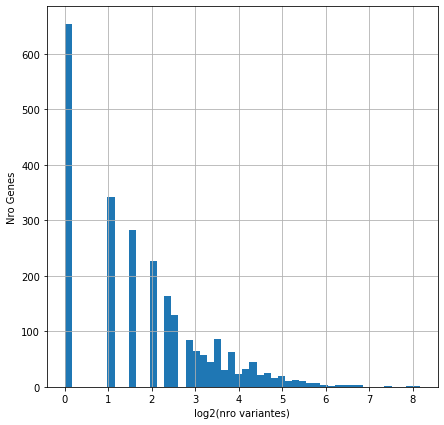

In [10]:
matplotlib.rcParams['figure.figsize'] = [7, 7]

print('Nro unique genes: %s'%missenseHC.base_hugo.nunique())
ax = missenseHC.base_hugo.value_counts().apply(np.log2).hist(bins = 50)
plt.xlabel('log2(nro variantes)')
plt.ylabel('Nro Genes')

In [11]:
# Cuáles son los genes que pueden sesgar el análisis? 
missenseHC.base_hugo.value_counts().head()

TTN      287
BRCA1    229
BRCA2    182
LDLR     170
SYNE2    109
Name: base_hugo, dtype: int64

### Dropping, spliting and saving data

In [20]:
removecols = ['ClinicalSignificance','OriginSimple','base_hugo','base_achange']
modeling_data = missenseHC.drop(removecols,axis =1)
modeling_data.clinSigSimple = modeling_data.clinSigSimple.apply(lambda x: int(x))  # float to intiger
modeling_data.rename(columns = {'clinSigSimple':'ClinvarHC'},inplace = True)
modeling_data.to_csv('./data/clinvarHC_modeling.csv.gz',sep = ',',compression = 'gzip')

In [21]:
X, y = modeling_data.drop(['ClinvarHC'],axis =1), modeling_data.ClinvarHC
display(X.shape)
y.shape

(17320, 39)

(17320,)

## Detectamos variables categóricas

In [38]:
categorical_feature_mask = X.dtypes==object       # esto nos da un vector booleano 
categorical_columns = X.columns[categorical_feature_mask].tolist()  # acá picnhamos los nombres de esas columnas
categorical_columns

['interpro_domain_simple',
 'ess_gene_ess_gene',
 'ess_gene_ess_gene_crispr',
 'ess_gene_ess_gene_crispr2',
 'ess_gene_ess_gene_gene_trap',
 'exac_gene_exac_cnv_flag']

## Manipulación de variables categóricas

### existen varios métodos para lidiar con variables categóricas y ordinales. 
* Los más básicos son:
    * LabelEncoder (sktlearn)         # sólo para variables ordinales o binarias
    * OneHotEncoder (sktlearn)        # variables categóricas (binarias o multicategoricas)
    * GetDummies  (nativo de Pandas)  # variables categórcias 
    * DictVectorizer (nativo de Pandas)

#### Por simplicidad ahora vamos a ver GetDummies (pero solo en esta etapa exploratoria de datos)
* Para construir el modelo necesitaremos de OneHotEncoder, o cualquier método que implemente métodos de tipo .fit_transform() 


In [39]:
# Get dummies
Xdummy = pd.get_dummies(X, prefix_sep='_', drop_first=True)
Xdummy.shape

(17320, 48)

In [41]:
Xdummy.columns[39::]

Index(['interpro_domain_simple_others', 'ess_gene_ess_gene_N',
       'ess_gene_ess_gene_crispr_N', 'ess_gene_ess_gene_crispr2_N',
       'ess_gene_ess_gene_crispr2_S', 'ess_gene_ess_gene_gene_trap_H',
       'ess_gene_ess_gene_gene_trap_K', 'ess_gene_ess_gene_gene_trap_N',
       'exac_gene_exac_cnv_flag_Y'],
      dtype='object')

#### Notar que ahora nuestro dataframe tiene 48 columnas

In [ ]:
#cg.ax_heatmap.get_
#cg.ax_heatmap.yaxis.get_ticklabels()

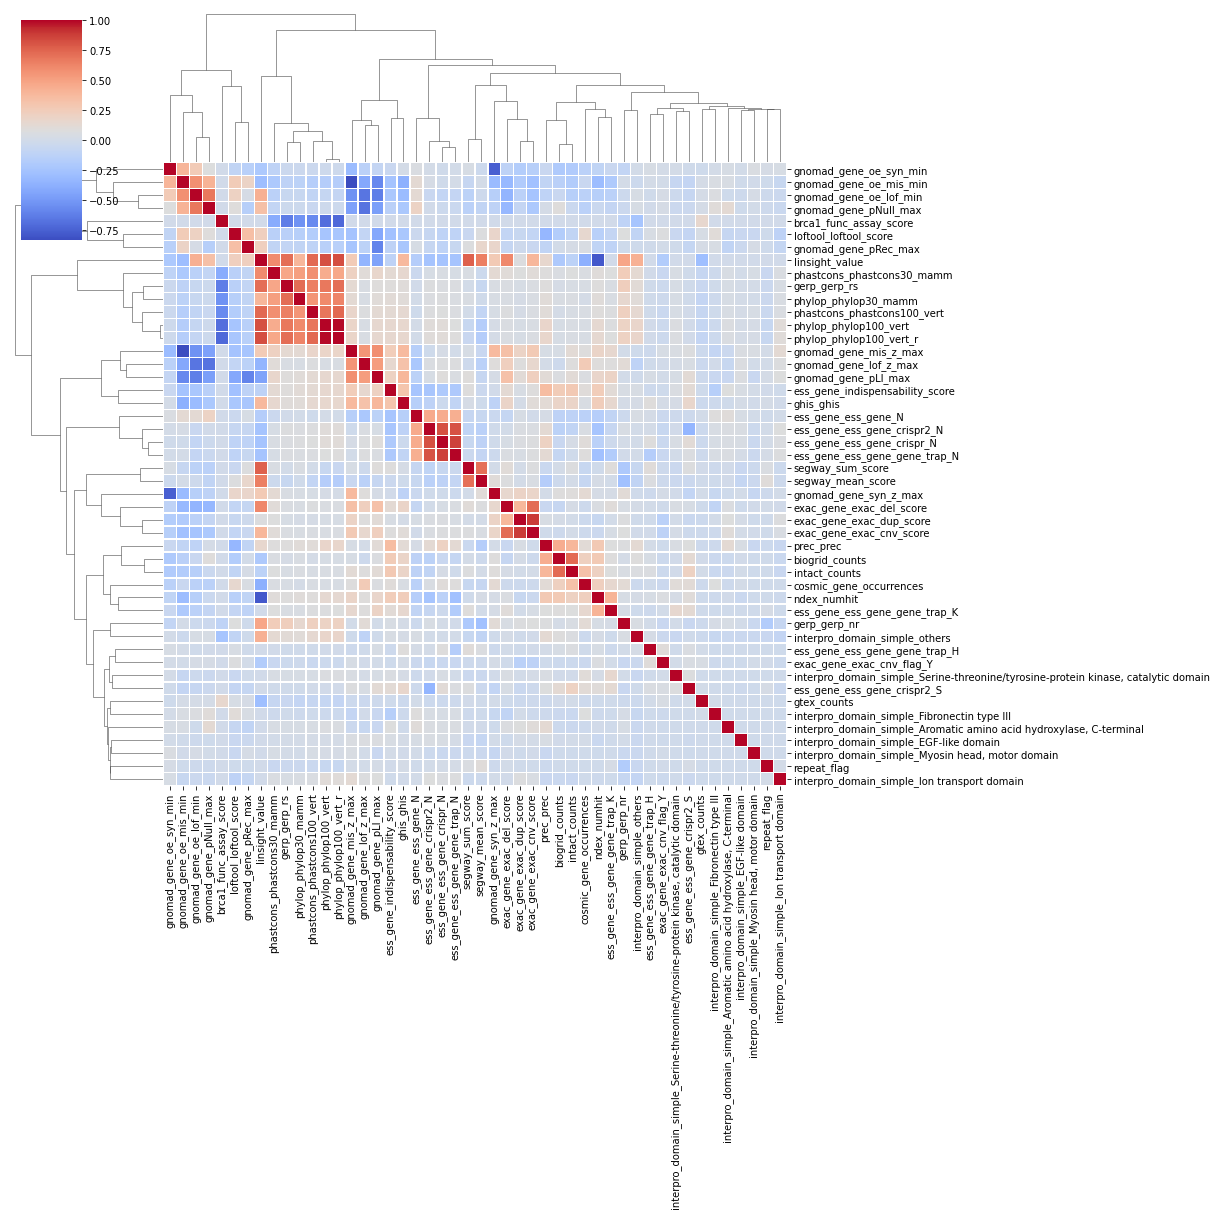

In [61]:
corr = Xdummy.corr()

cg = sns.clustermap(corr.fillna(0), cmap ='coolwarm', linewidths = 0.2,
                    method = 'complete', xticklabels=1,figsize = (17,17)) 
cg

## Clustering. Homework, cómo se agrupan estos features?

# Recomiendo fuertemente utilizar R para TODO lo que sea clustring





In [62]:
from scipy.cluster.hierarchy import fcluster
linkage = cg.dendrogram_row.linkage

t = 0.9
clust = fcluster(linkage, t, criterion='inconsistent')
## Si quisiera cortar por numero de clusters:
#k = 10
#clust = fcluster(linkage, k, criterion='maxclust')
#clust


clusters = pd.DataFrame({'feature':Xdummy.columns,'cluster':clust}).sort_values(by = ['cluster'])
#clusters


__[inconsistent Links (dendrogram)](http://cda.psych.uiuc.edu/multivariate_fall_2013/matlab_help/cluster_analysis.pdf
)__

### Qué proporción de Nulls hay en las variables? 
* Cómo podemos tratar esos Nulls?
* Un modelo como regresion logística no admite Nulls. 
* Hay que imputarlos. 
  * La estrategia más simple sería con el valor medio de ese feature en el dataset. Pero, eso es robusto a outliers?  
  * Y si usamos la Mediana?

  

In [82]:
#matplotlib.rcParams['figure.figsize'] = [6, 6]
#nans = Xdummy.apply(lambda a: a.isna().sum()/a.shape[0],axis =0)  # 
#p = nans[nans>0.1].plot(kind = 'bar',title = 'Principales features con Nulls')
#p.set_ylabel('Null Fraction')

Se puede (y deberíamos hacerlo) extender el análisis de los datos. 
* PCA
* Significancia de las correlaciones halladas.
* Qué tipo distribución tienen los features?



### Finalmente, preparo sets de entrenamiento:
* Porcentajes arbitrarios, sólo basados en la práctica y son dependientes de la cantidad de datos. 

* Training  Set (60%)         #Estos  lo usamos para entrenar el modelo
    * Contendrá al evaluation set (lo sacaremos vía validación cruzada)   

* Test Set 40%.              #Este no lo tocamos nunca para entrenar ni para totmar decisiones. Es nuestra medida no sesgada del error de generalización

> Bloque con sangría

> Bloque con sangría






